# Table of Contents
* [TODO](#TODO)
* [Imports](#Imports)
* [Configs](#Configs)
	* [Autoencoder (ae_cfg)](#Autoencoder-%28ae_cfg%29)
	* [Euclidean Depth (depth_cfg)](#Euclidean-Depth-%28depth_cfg%29)
* [Utils](#Utils)
	* [Modules](#Modules)
		* [acts = {'none', 'tanh', 'sigmoid'}](#acts-=-{'none',-'tanh',-'sigmoid'})
		* [init_weights(net, init_type=('normal', ['normal', 'xavier', 'kaiming', 'orthogonal']), gain=0.02)](#init_weights%28net,-init_type=%28'normal',-['normal',-'xavier',-'kaiming',-'orthogonal']%29,-gain=0.02%29)
	* [Misc](#Misc)
* [Models](#Models)
	* [PLModel(cfg)](#PLModel%28cfg%29)
		* [rescale(data, low, high)](#rescale%28data,-low,-high%29)
* [Modules](#Modules)
	* [Backbone()](#Backbone%28%29)
	* [Midreps(normalize_outputs=True)](#Midreps%28normalize_outputs=True%29)
	* [Decoder(output_act='none', out_channels=3, *args, **kwargs)](#Decoder%28output_act='none',-out_channels=3,-*args,-**kwargs%29)
	* [Discriminator (TODO)](#Discriminator-%28TODO%29)
		* [NLayerDiscriminator(input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False)](#NLayerDiscriminator%28input_nc,-ndf=64,-n_layers=3,-norm_layer=nn.BatchNorm2d,-use_sigmoid=False%29)
		* [PixelDiscriminator(input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False)](#PixelDiscriminator%28input_nc,-ndf=64,-norm_layer=nn.BatchNorm2d,-use_sigmoid=False%29)
* [Losses (TODO)](#Losses-%28TODO%29)
* [Data Processing (TODO)](#Data-Processing-%28TODO%29)
* [Scratchpad](#Scratchpad)
	* [Depthmap](#Depthmap)


# TODO

* [ ] Configs
    * [ ] Autoencoder
* [ ] Networks
    * [ ] Backbone
        * [x] Architecture
        * [ ] Initialization
    * [ ] Midreps
        * [x] Architecture
        * [ ] Initialization
    * [ ] Decoder
        * [x] Architecture
        * [ ] Initialization
    * [ ] Pix2Pix Discriminator
        * [ ] Architecture
        * [ ] Initialization
    * [ ] PixelGAN Discriminator
        * [ ] Architecture
        * [ ] Initialization
* [ ] Data
* [ ] Training
    * [ ] Weight decay
    * [ ] Multitask multipliers

# Imports

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import os.path as osp
import sys
import functools

from easydict import EasyDict as edict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import visualpriors
import pytorch_lightning as pl
from torchsummaryX import summary

# Configs

## Base

In [ ]:
base_cfg = edict()


## Autoencoder (ae_cfg)

In [39]:
ae_cfg = edict()

ae_cfg.train = edict()
ae_cfg.train.num_epochs = 30
ae_cfg.train.weight_decay = edict()
ae_cfg.train.weight_decay.default = 2e-6
ae_cfg.train.weight_decay.discriminator = 10 * ae_cfg.train.weight_decay.default

ae_cfg.model = edict()
ae_cfg.model.discriminator = edict()
ae_cfg.model.discriminator.type = "nlayerdicriminator"
ae_cfg.model.discriminator.n_layers = 5
ae_cfg.model.discriminator.stride = 4
ae_cfg.model.discriminator.n_channel_multiplier = 64

## Euclidean Depth (depth_cfg)

In [40]:
depth_cfg = edict()
depth_cfg.gpus = 0

depth_cfg.train = edict()
depth_cfg.train.batch_size = 32
depth_cfg.train.num_workers = 4
depth_cfg.train.num_epochs = 30
depth_cfg.train.weight_decay = edict()
depth_cfg.train.weight_decay.default = 2e-6
depth_cfg.train.weight_decay.discriminator = 10 * depth_cfg.train.weight_decay.default
depth_cfg.train.lambdas = edict()
depth_cfg.train.lambdas.lnorm = 0.996
depth_cfg.train.lambdas.gan = 0.004
depth_cfg.train.lrs = edict()
depth_cfg.train.lrs.default = 1e-4
depth_cfg.train.lrs.discriminator = 1e-5

depth_cfg.model = edict()

depth_cfg.model.backbone = edict()
depth_cfg.model.backbone.kwargs = edict()

depth_cfg.model.midreps = edict()
depth_cfg.model.midreps.kwargs = edict()
depth_cfg.model.midreps.kwargs.normalize_outputs = True

depth_cfg.model.decoder = edict()
depth_cfg.model.decoder.kwargs = edict()
depth_cfg.model.decoder.kwargs.output_act = "none"
depth_cfg.model.decoder.kwargs.out_channels = 3

depth_cfg.model.discriminator = edict()
depth_cfg.model.discriminator.type = "nlayerdicriminator"
depth_cfg.model.discriminator.kwargs = edict()
depth_cfg.model.discriminator.kwargs.n_layers = 5
depth_cfg.model.discriminator.kwargs.stride = 4
depth_cfg.model.discriminator.kwargs.ndf = 64

# Utils

## Modules

### acts = {'none', 'tanh', 'sigmoid'}

In [41]:
acts = {"none": nn.Identity, "tanh": nn.Tanh, "sigmoid": nn.Sigmoid}

### init_weights(net, init_type=('normal', ['normal', 'xavier', 'kaiming', 'orthogonal']), gain=0.02)

In [42]:
def init_weights(net, init_type="normal", gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, "weight") and (
            classname.find("Conv") != -1 or classname.find("Linear") != -1
        ):
            if init_type == "normal":
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == "xavier":
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == "kaiming":
                init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
            elif init_type == "orthogonal":
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError(
                    "initialization method [%s] is not implemented" % init_type
                )
            if hasattr(m, "bias") and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print("initialize network with %s" % init_type)
    net.apply(init_func)

## Misc

### rescale(data, low, high)

In [43]:
def rescale(data, low, high):
    return (data - low) / (high - low)

# Modules

## Backbone(layers=[3, 4, 6, 3])

In [44]:
# For making a (Hp x Wp x 2048) feature map commmon for all tasks
class Backbone(visualpriors.taskonomy_network.TaskonomyEncoder):
    def __init__(self, layers=[3, 4, 6, 3]):
        # def __init__(self, normalize_outputs=True, eval_only=True, train_penultimate=False, train=False):
        self.inplanes = 64
        super(visualpriors.taskonomy_network.TaskonomyEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        block = visualpriors.taskonomy_network.Bottleneck
        # layers = [3, 4, 6, 3]
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2])
        self.layer4 = self._make_layer(block, 512, layers[3])
        # self.compress1 = nn.Conv2d(2048, 8, kernel_size=3, stride=1, padding=1, bias=False)
        # self.compress_bn = nn.BatchNorm2d(8)
        # self.relu1 = nn.ReLU(inplace=True)
        # self.groupnorm = nn.GroupNorm(8, 8, affine=False)
        # self.normalize_outputs = normalize_outputs
        # self.eval_only = eval_only
        # if self.eval_only:
        #     self.eval()
        # for p in self.parameters():
        #     p.requires_grad = False

        # if train_penultimate:
        #     for name, param in self.named_parameters():
        #         if 'compress' in name:  # last layers: compress1.weight, compress_bn.weight, compress_bn.bias
        #             param.requires_grad = True
        #         else:
        #             param.requires_grad = False

        # if train:
        #     for p in self.parameters():
        #         p.requires_grad = True

    def forward(self, x):
        x = F.pad(x, pad=(3, 3, 3, 3), mode="constant", value=0)
        #  other modes are reflect, replicate, constant

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = F.pad(x, (0,1,0,1), 'constant', 0)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.compress1(x)
        # x = self.compress_bn(x)
        # x = self.relu1(x)
        # if self.normalize_outputs:
        #     x = self.groupnorm(x)
        return x

    def train(self, val=True):
        # if val and self.eval_only:
        #     warnings.warn("Ignoring 'train()' in TaskonomyEncoder since 'eval_only' was set during initialization.", RuntimeWarning)
        # else:
        # return super(TaskonomyEncoder, self).train(val)
        return nn.Module.train(self, val)

In [45]:
backbone = Backbone()
summary(backbone, torch.randn(1, 3, 224, 224))

                                             Kernel Shape       Output Shape  \
Layer                                                                          
0_conv1                                     [3, 64, 7, 7]  [1, 64, 112, 112]   
1_bn1                                                [64]  [1, 64, 112, 112]   
2_relu                                                  -  [1, 64, 112, 112]   
3_maxpool                                               -    [1, 64, 56, 56]   
4_layer1.0.Conv2d_conv1                    [64, 64, 1, 1]    [1, 64, 56, 56]   
5_layer1.0.BatchNorm2d_bn1                           [64]    [1, 64, 56, 56]   
6_layer1.0.ReLU_relu                                    -    [1, 64, 56, 56]   
7_layer1.0.Conv2d_conv2                    [64, 64, 3, 3]    [1, 64, 56, 56]   
8_layer1.0.BatchNorm2d_bn2                           [64]    [1, 64, 56, 56]   
9_layer1.0.ReLU_relu                                    -    [1, 64, 56, 56]   
10_layer1.0.Conv2d_conv3                

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 64, 7, 7]","[1, 64, 112, 112]",9408.0,118013952.0
1_bn1,[64],"[1, 64, 112, 112]",128.0,64.0
2_relu,-,"[1, 64, 112, 112]",NaN,NaN
3_maxpool,-,"[1, 64, 56, 56]",NaN,NaN
4_layer1.0.Conv2d_conv1,"[64, 64, 1, 1]","[1, 64, 56, 56]",4096.0,12845056.0
5_layer1.0.BatchNorm2d_bn1,[64],"[1, 64, 56, 56]",128.0,64.0
6_layer1.0.ReLU_relu,-,"[1, 64, 56, 56]",NaN,NaN
7_layer1.0.Conv2d_conv2,"[64, 64, 3, 3]","[1, 64, 56, 56]",36864.0,115605504.0
8_layer1.0.BatchNorm2d_bn2,[64],"[1, 64, 56, 56]",128.0,64.0


## Midreps(normalize_outputs=True)

In [46]:
# Transform the (Hp x Wp x 2048) feature map to a task-specific feature map of (Hp x Wp x 8)
class MidReps(nn.Module):
    def __init__(self, normalize_outputs=True):
        super().__init__()
        self.compress1 = nn.Conv2d(
            2048, 8, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.compress_bn = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU(inplace=True)
        self.normalize_outputs = normalize_outputs
        if self.normalize_outputs:
            self.groupnorm = nn.GroupNorm(8, 8, affine=False)

    def forward(self, x):
        x = self.compress1(x)
        x = self.compress_bn(x)
        x = self.relu1(x)
        if self.normalize_outputs:
            x = self.groupnorm(x)
        return x

In [47]:
midreps = MidReps()
summary(midreps, backbone(torch.randn(1, 3, 224, 224)))

                  Kernel Shape    Output Shape    Params   Mult-Adds
Layer                                                               
0_compress1    [2048, 8, 3, 3]  [1, 8, 14, 14]  147.456k  28.901376M
1_compress_bn              [8]  [1, 8, 14, 14]      16.0         8.0
2_relu1                      -  [1, 8, 14, 14]         -           -
3_groupnorm                  -  [1, 8, 14, 14]         -           -
--------------------------------------------------------------------
                          Totals
Total params            147.472k
Trainable params        147.472k
Non-trainable params         0.0
Mult-Adds             28.901384M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_compress1,"[2048, 8, 3, 3]","[1, 8, 14, 14]",147456.0,28901376.0
1_compress_bn,[8],"[1, 8, 14, 14]",16.0,8.0
2_relu1,-,"[1, 8, 14, 14]",NaN,NaN
3_groupnorm,-,"[1, 8, 14, 14]",NaN,NaN


## Decoder(output_act='none', out_channels=3, *args, **kwargs)

In [48]:
# Decode the (Hp x Wp x 8) feature map to it's specific task
class Decoder(visualpriors.taskonomy_network.TaskonomyDecoder):
    def __init__(self, output_act='none', out_channels=3, eval_only=False, *args, **kwargs):
        nn.Module.__init__(self)
        self.output_act = output_act
        act = acts[output_act]()
            
        self.conv2 = self._make_layer(8, 512)
        self.conv3 = self._make_layer(512, 512)
        # self.conv4 = self._make_layer(1024, 512)
        self.conv4 = nn.Identity()
        self.conv5 = self._make_layer(512, 256)
        self.conv6 = self._make_layer(256, 256)
        self.conv7 = self._make_layer(256, 128)

        self.deconv8 = self._make_layer(128, 64, stride=2, deconv=True)
        self.conv9 = self._make_layer(64, 64)

        self.deconv10 = self._make_layer(64, 32, stride=2, deconv=True)
        self.conv11 = self._make_layer(32, 32)

        self.deconv12 = self._make_layer(32, 16, stride=2, deconv=True)
        self.conv13 = self._make_layer(16, 32)

        self.deconv14 = self._make_layer(32, 16, stride=2, deconv=True)
        self.decoder_output = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, bias=True, padding=1),
            act,
        )

In [49]:
decoder = Decoder()
summary(decoder, midreps(backbone(torch.randn(1, 3, 224, 224))))

                                   Kernel Shape       Output Shape     Params  \
Layer                                                                           
0_conv2.Conv2d_0                 [8, 512, 3, 3]   [1, 512, 14, 14]    36.864k   
1_conv2.BatchNorm2d_1                     [512]   [1, 512, 14, 14]     1.024k   
2_conv2.LeakyReLU_2                           -   [1, 512, 14, 14]          -   
3_conv3.Conv2d_0               [512, 512, 3, 3]   [1, 512, 14, 14]  2.359296M   
4_conv3.BatchNorm2d_1                     [512]   [1, 512, 14, 14]     1.024k   
5_conv3.LeakyReLU_2                           -   [1, 512, 14, 14]          -   
6_conv4                                       -   [1, 512, 14, 14]          -   
7_conv5.Conv2d_0               [512, 256, 3, 3]   [1, 256, 14, 14]  1.179648M   
8_conv5.BatchNorm2d_1                     [256]   [1, 256, 14, 14]      512.0   
9_conv5.LeakyReLU_2                           -   [1, 256, 14, 14]          -   
10_conv6.Conv2d_0           

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv2.Conv2d_0,"[8, 512, 3, 3]","[1, 512, 14, 14]",36864.0,7225344.0
1_conv2.BatchNorm2d_1,[512],"[1, 512, 14, 14]",1024.0,512.0
2_conv2.LeakyReLU_2,-,"[1, 512, 14, 14]",NaN,NaN
3_conv3.Conv2d_0,"[512, 512, 3, 3]","[1, 512, 14, 14]",2359296.0,462422016.0
4_conv3.BatchNorm2d_1,[512],"[1, 512, 14, 14]",1024.0,512.0
5_conv3.LeakyReLU_2,-,"[1, 512, 14, 14]",NaN,NaN
6_conv4,-,"[1, 512, 14, 14]",NaN,NaN
7_conv5.Conv2d_0,"[512, 256, 3, 3]","[1, 256, 14, 14]",1179648.0,231211008.0
8_conv5.BatchNorm2d_1,[256],"[1, 256, 14, 14]",512.0,256.0


## Discriminator (TODO)

### NLayerDiscriminator(input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False)

In [50]:
class NLayerDiscriminator(nn.Module):
    def __init__(
        self,
        input_nc,
        ndf=64,
        n_layers=3,
        norm_layer=nn.BatchNorm2d,
        stride=2,
        use_sigmoid=False,
        out_pool=True,
    ):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=stride, padding=padw),
            nn.LeakyReLU(0.2, True),
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(
                    ndf * nf_mult_prev,
                    ndf * nf_mult,
                    kernel_size=kw,
                    stride=stride,
                    padding=padw,
                    bias=use_bias,
                ),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True),
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(
                ndf * nf_mult_prev,
                ndf * nf_mult,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=use_bias,
            ),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True),
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=0)]
        if out_pool:
            sequence += [nn.AdaptiveAvgPool2d((1, 1))]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [51]:
nlayer_discriminator = NLayerDiscriminator(
    input_nc=3,
    n_layers=ae_cfg.model.discriminator.n_layers,
    ndf=ae_cfg.model.discriminator.n_channel_multiplier,
    # stride=ae_cfg.model.discriminator.stride,
    stride=2,
)
print(nlayer_discriminator)
summary(nlayer_discriminator, torch.randn(1, 3, 224, 224))

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momen

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Conv2d_0,"[3, 64, 4, 4]","[1, 64, 112, 112]",3136.0,38535168.0
1_model.LeakyReLU_1,-,"[1, 64, 112, 112]",NaN,NaN
2_model.Conv2d_2,"[64, 128, 4, 4]","[1, 128, 56, 56]",131072.0,411041792.0
3_model.BatchNorm2d_3,[128],"[1, 128, 56, 56]",256.0,128.0
4_model.LeakyReLU_4,-,"[1, 128, 56, 56]",NaN,NaN
5_model.Conv2d_5,"[128, 256, 4, 4]","[1, 256, 28, 28]",524288.0,411041792.0
6_model.BatchNorm2d_6,[256],"[1, 256, 28, 28]",512.0,256.0
7_model.LeakyReLU_7,-,"[1, 256, 28, 28]",NaN,NaN
8_model.Conv2d_8,"[256, 512, 4, 4]","[1, 512, 14, 14]",2097152.0,411041792.0


### PixelDiscriminator(input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False)

In [52]:
class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias),
        ]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        return self.net(input)

In [53]:
PixelDiscriminator(3)

PixelDiscriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)

# Models

## PLModel(cfg)

In [54]:
class PLModel(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        model_cfg = cfg.model

        self.backbone = Backbone(**model_cfg.backbone.kwargs)
        self.midreps = MidReps(**model_cfg.midreps.kwargs)
        self.decoder = Decoder(**model_cfg.decoder.kwargs)

        # self.discriminator = None
        # if 'discriminator' in model_cfg and bool(model_cfg.discriminator):
        #     self.discriminator = NLayerDiscriminator(
        #         input_nc=6,
        #         **model_cfg.discriminator.kwargs
        #     )

    def forward(self, x):
        bb_feats = self.backbone(x)
        midreps = self.midreps(bb_feats)
        return self.decoder(midreps), edict(backbone=bb_feats, midreps=midreps)

In [55]:
PLModel(depth_cfg)(torch.randn(1, 3, 224, 224))

(tensor([[[[-6.3416e-02, -8.7219e-02, -1.4580e-01,  ..., -6.4563e-02,
            -9.6488e-02,  3.1298e-02],
           [ 9.5686e-02, -8.5141e-02, -1.4797e-01,  ..., -6.6084e-02,
            -9.4875e-02, -3.9229e-02],
           [ 8.8928e-02, -2.0259e-01,  7.0182e-02,  ..., -2.2309e-01,
            -2.2709e-02, -5.3347e-02],
           ...,
           [ 1.7497e-01, -8.5295e-02, -3.3533e-04,  ..., -4.3416e-02,
            -2.6261e-01,  3.6345e-02],
           [ 7.5055e-02, -1.5075e-01,  2.5632e-01,  ..., -1.9312e-01,
            -4.3487e-04, -1.0126e-01],
           [-2.2910e-02, -1.8140e-01,  1.1093e-01,  ..., -4.5454e-01,
            -2.2900e-01, -2.1046e-02]],
 
          [[ 7.2787e-02,  2.1251e-03, -2.3637e-01,  ..., -8.3141e-02,
            -8.3943e-02, -2.0512e-01],
           [ 2.3145e-01,  5.0325e-02,  2.6232e-01,  ...,  2.2768e-03,
             1.7770e-01,  4.2565e-02],
           [ 1.4141e-01, -1.2243e-01, -4.9109e-03,  ...,  1.3991e-01,
            -1.9814e-01,  8.0561e-02],


# Losses (TODO)

# Data Processing (TODO)

In [70]:
import glob
from torch.utils import data
import OpenEXR as exr
import Imath
from skimage.transform import resize


def readEXR(filename):
    """Read color + depth data from EXR image file.
    
    Parameters
    ----------
    filename : str
        File path.
        
    Returns
    -------
    img : RGB or RGBA image in float32 format. Each color channel
          lies within the interval [0, 1].
          Color conversion from linear RGB to standard RGB is performed
          internally. See https://en.wikipedia.org/wiki/SRGB#The_forward_transformation_(CIE_XYZ_to_sRGB)
          for more information.
          
    Z : Depth buffer in float32 format or None if the EXR file has no Z channel.
    """

    exrfile = exr.InputFile(filename)
    header = exrfile.header()

    dw = header["dataWindow"]
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)

    channelData = dict()

    # convert all channels in the image to numpy arrays
    for c in header["channels"]:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.frombuffer(C, dtype=np.float32)
        C = np.reshape(C, isize)

        channelData[c] = C

    colorChannels = (
        ["R", "G", "B", "A"] if "A" in header["channels"] else ["R", "G", "B"]
    )
    img = np.concatenate(
        [channelData[c][..., np.newaxis] for c in colorChannels], axis=2
    )

    # linear to standard RGB
    # img[..., :3] = np.where(img[..., :3] <= 0.0031308,
    #                       12.92 * img[..., :3],
    #                        1.055 * np.power(img[..., :3], 1 / 2.4) - 0.055)

    # sanitize image to be in range [0, 1]
    # img = np.where(img < 0.0, 0.0, np.where(img > 1.0, 1, img))

    Z = None if "Z" not in header["channels"] else channelData["Z"]

    return img, Z


def default_loader(path):
    return Image.open(path).convert("RGB")


def exr_loader(path):
    return readEXR(path)[0]


def get_depth(img_fp):
    return 1 - get_exr_replace(img_fp, "depths")[:, :, [0]]


def get_normal(img_fp):
    return get_exr_replace(img_fp, "normals")


def get_shadeless(img_fp):
    return default_loader(img_fp.replace("images", "shadeless"))


def get_exr_replace(img_fp, folder_replace):
    return exr_loader(
        img_fp.replace("images", folder_replace).replace(".png", "_0001.exr")
    )


class CLEVRMidrepsDataset(data.Dataset):
    get_fns = {
        "depths": get_depth,
        "normals": get_normal,
        "shadeless": get_shadeless,
    }
    default_img_transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor()]
    )
    default_midreps_transforms = transforms.Compose(
        [
            lambda img: resize(img, (224, 224), preserve_range=True).transpose(2, 0, 1),
            torch.from_numpy,
        ]
    )

    def __init__(
        self,
        base_dir,
        split="train",
        match="*.png",
        transform=None,
        loader=default_loader,
        midreps=[],
        midreps_transform=None,
    ):
        self.midreps = midreps
        self.transform = transform
        self.midreps_transform = midreps_transform
        self.loader = loader
        self.base_dir = base_dir
        self.files = sorted(glob.glob(os.path.join(base_dir, "images", split, match)))

    def __getitem__(self, index, midreps=None):
        midreps = midreps if midreps is not None else self.midreps
        img_fp = self.files[index]
        img = self.loader(img_fp)
        data = {midrep: self.get_fns[midrep](img_fp) for midrep in midreps}

        if self.transform is not None:
            img = self.transform(img)
        if self.midreps_transform is not None:
            data = {k: self.midreps_transform(v) for k, v in data.items()}

        return img, edict(data)

    def __len__(self):
        return len(self.files)

In [59]:
img_dataset = CLEVRMidrepsDataset(
    "/Users/sebamenabar/Documents/datasets/tmp/CLEVR_v1.2/",
    transform=transforms.Resize((224, 224)),
    midreps_transform=CLEVRMidrepsDataset.default_midreps_transforms,
)

In [60]:
img, data = img_dataset.__getitem__(0, ["depths", "normals"])

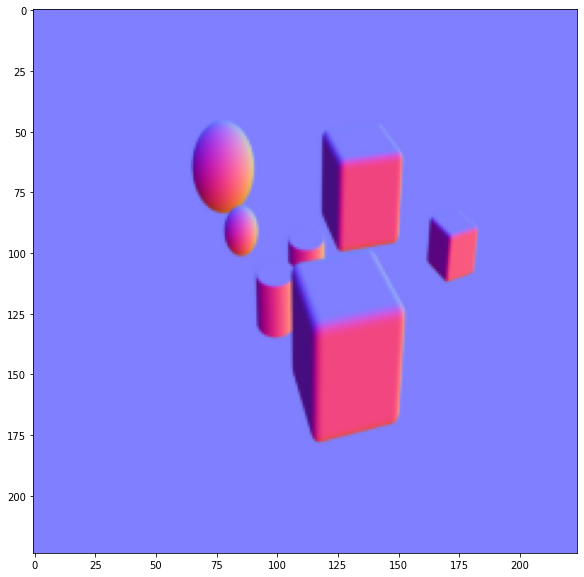

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
sthing = ax.imshow(data.normals)
# plt.colorbar(sthing)

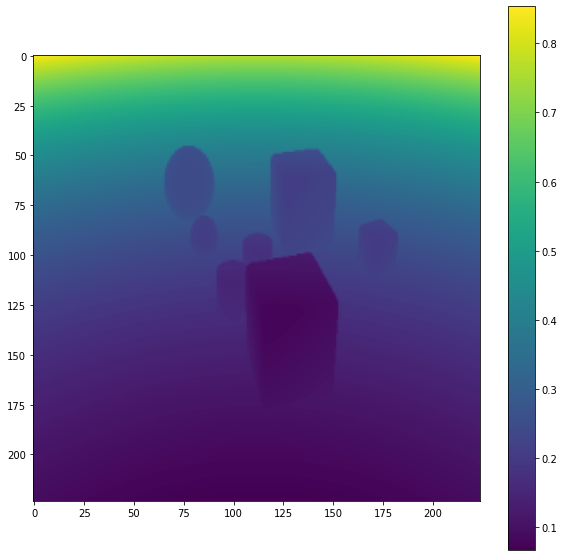

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
sthing = ax.imshow(resize(data.depths, (224, 224)))
plt.colorbar(sthing)

# Train

In [57]:
class ModelTrainer(PLModel):
    def __init__(self, cfg):
        super().__init__(cfg)
        # self.bce = nn.BCEWithLogitsLoss(reduction="mean")
        if cfg.train.lnorm == 'l1':
            self.lnorm = nn.L1Loss(reduction='none')
        elif cfg.train.lnorm == 'l2':
            self.lnorm = nn.MSELoss(reduction='none')
        elif cfg.train.lnorm == 'smooth_l1':
            self.lnorm = nn.SmoothL1Loss(reduction='none')

    def prepare_data(self):
        self.train_ds = CLEVRMidrepsDataset(
            self.cfg.train.base_data_dir,
            midreps=["depths"],
            split="train",
            transform=CLEVRMidrepsDataset.default_img_transform,
            midreps_transform=CLEVRMidrepsDataset.default_midreps_transforms,
        )

    @property
    def use_cuda(self):
        return self.cfg.gpus != 0

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.cfg.train.batch_size,
            shuffle=True,
            num_workers=self.cfg.train.num_workers,
            pin_memory=self.use_cuda,
            drop_last=True,
        )

    def configure_optimizers(self):
        return torch.optim.Adam(
            list(self.backbone.parameters())
            + list(self.midreps.parameters())
            + list(self.decoder.parameters()),
            lr=self.cfg.train.lrs.default,
            weight_decay=self.cfg.train.weight_decay.default,
        )

    def training_step(self, batch, batch_nb):
        img, midreps = batch
        midreps = edict(midreps)
        recon, features = self(img)
        # recon_loss = self.lnorm(recon, img)
        depth_loss = self.lnorm(recon, midreps.depths)
        loss = depth_loss.flatten(1).sum(1).mean() # channel wise-mean, img-wise sum, batch-wise sum

        return dict(loss=loss)

In [58]:
depth_cfg.train.lnorm = 'smooth_l1'
depth_cfg.train.lrs.default = 2e-5
if torch.cuda.is_available():
    depth_cfg.train.base_data_dir = '/storage1/samenabar/code/CLMAC/clevr-dataset-gen/datasets/CLEVR_v1.2/'
    depth_cfg.gpus = 1
    depth_cfg.train.num_workers = 8
else:
    depth_cfg.train.base_data_dir = '/Users/sebamenabar/Documents/datasets/tmp/CLEVR_v1.2'
    depth_cfg.gpus = 0
    depth_cfg.train.num_workers = 4
    
depth_cfg.model.decoder.kwargs.out_channels = 1
depth_cfg.model.decoder.kwargs.output_act = 'sigmoid'
depth_cfg.model.backbone.kwargs.layers = [2, 2, 2, 2]

depth_cfg

{'gpus': 0,
 'train': {'batch_size': 32,
  'num_workers': 4,
  'num_epochs': 30,
  'weight_decay': {'default': 2e-06, 'discriminator': 1.9999999999999998e-05},
  'lambdas': {'lnorm': 0.996, 'gan': 0.004},
  'lrs': {'default': 2e-05, 'discriminator': 1e-05},
  'lnorm': 'smooth_l1',
  'base_data_dir': '/Users/sebamenabar/Documents/datasets/tmp/CLEVR_v1.2'},
 'model': {'backbone': {'kwargs': {'layers': [2, 2, 2, 2]}},
  'midreps': {'kwargs': {'normalize_outputs': True}},
  'decoder': {'kwargs': {'output_act': 'sigmoid', 'out_channels': 1}},
  'discriminator': {'type': 'nlayerdicriminator',
   'kwargs': {'n_layers': 5, 'stride': 4, 'ndf': 64}}}}

In [80]:
discriminator = NLayerDiscriminator(n_layers=5, stride=4)

TypeError: __init__() missing 1 required positional argument: 'input_nc'

In [77]:
depth_cfg.train.lnorm = 'smooth_l1'
model = ModelTrainer(depth_cfg)

In [145]:
trainer = pl.Trainer(
    gpus=depth_cfg.gpus,
    logger=False,
    checkpoint_callback=None,
    max_epochs=10,
)
trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:Set SLURM handle signals.
INFO:lightning:
    | Name                           | Type            | Params
---------------------------------------------------------------
0   | backbone                       | Backbone        | 13 M  
1   | backbone.conv1                 | Conv2d          | 9 K   
2   | backbone.bn1                   | BatchNorm2d     | 128   
3   | backbone.relu                  | ReLU            | 0     
4   | backbone.maxpool               | MaxPool2d       | 0     
5   | backbone.layer1                | Sequential      | 145 K 
6   | backbone.layer1.0              | Bottleneck      | 75 K  
7   | backbone.layer1.0.conv1        | Conv2d          | 4 K   
8   | backbone.layer1.0.bn1          | BatchNorm2d     | 128   
9   | backbone.layer1.0.conv2        | Conv2d          | 36 K  
10  | backbone.layer1.0.bn2          | BatchNorm2d     | 128   
11  | backbone.layer1.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1

In [71]:
dataset = CLEVRMidrepsDataset(
    depth_cfg.train.base_data_dir,
    split="train",
    midreps=["depths"],
    transform=CLEVRMidrepsDataset.default_img_transform,
    midreps_transform=CLEVRMidrepsDataset.default_midreps_transforms,
)

In [72]:
dataset[0][1].depths.size()

torch.Size([1, 224, 224])

In [73]:
sample = dataset[0]
img = sample[0]
depth = sample[1].depths

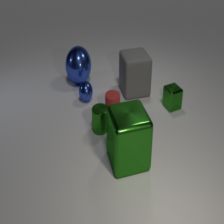

In [74]:
T.functional.to_pil_image(img)

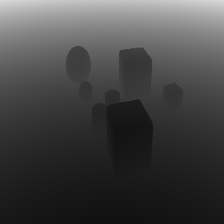

In [75]:
 T.functional.to_pil_image(depth.cpu())

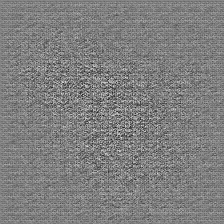

In [79]:
T.functional.to_pil_image(model(img.unsqueeze(0))[0].transpose(2, 3)[0].cpu())

In [83]:
model(sample)[0]

tensor([[[[0.4419, 0.4289, 0.4208,  ..., 0.4242, 0.4141, 0.4546],
          [0.4411, 0.3947, 0.3872,  ..., 0.4008, 0.4062, 0.4274],
          [0.4076, 0.3948, 0.3861,  ..., 0.3964, 0.3774, 0.4336],
          ...,
          [0.4183, 0.4281, 0.4093,  ..., 0.5850, 0.4750, 0.4325],
          [0.4213, 0.3820, 0.3822,  ..., 0.5159, 0.4894, 0.4369],
          [0.4617, 0.3970, 0.4518,  ..., 0.5343, 0.5390, 0.4838]],

         [[0.4582, 0.4345, 0.4534,  ..., 0.4535, 0.4507, 0.4802],
          [0.4189, 0.3977, 0.3886,  ..., 0.3844, 0.3962, 0.4484],
          [0.4331, 0.4182, 0.3950,  ..., 0.3923, 0.3984, 0.4349],
          ...,
          [0.4224, 0.3414, 0.3710,  ..., 0.4910, 0.4064, 0.4034],
          [0.4359, 0.4135, 0.3739,  ..., 0.5286, 0.4845, 0.4484],
          [0.4461, 0.4418, 0.3882,  ..., 0.6079, 0.4518, 0.4852]],

         [[0.4490, 0.4156, 0.4423,  ..., 0.4357, 0.4451, 0.4537],
          [0.4094, 0.4170, 0.4092,  ..., 0.4148, 0.4048, 0.4377],
          [0.4145, 0.3960, 0.3853,  ..., 0

# Scratchpad

## Depthmap

In [76]:
import numpy as np
from PIL import Image

In [103]:
img = Image.open(
    "/Users/sebamenabar/Downloads/taskonomy-sample-model-1-master/depth_euclidean/point_0_view_0_domain_depth_euclidean.png"
)
# img = img.convert('RGB')

In [104]:
import numpy as np

In [105]:
def resize_and_rescale_image_log(img, new_dims, offset=1.0, normalizer=1.0):
    """
        Resizes and rescales an img to log-linear
        
        Args:
            img: A np array
            offset: Shifts values by offset before taking log. Prevents 
                taking the log of a negative number
            normalizer: divide by the normalizing factor after taking log
        Returns:
            rescaled_image
    """
    img = np.log(float(offset) + img) / normalizer
    #  img = resize_image(img, new_dims)
    return img

In [106]:
import matplotlib.pyplot as plt

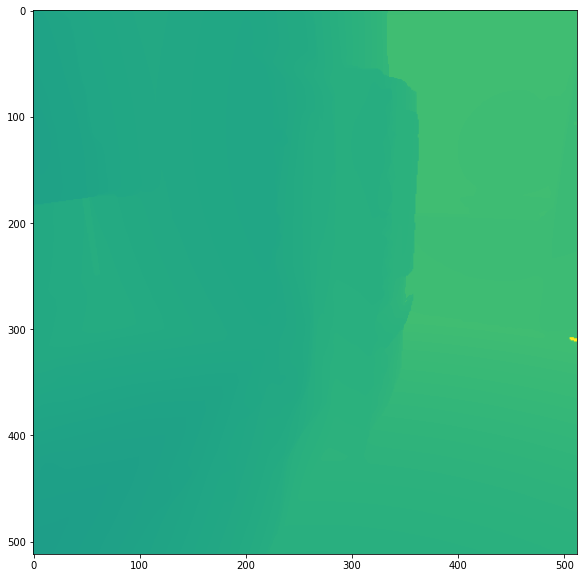

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    resize_and_rescale_image_log(np.array(img), None, 1, np.log(2.0 ** 16.0)),
    vmin=0,
    vmax=1,
)

In [95]:
from PIL import Image
import torchvision.transforms.functional as TF
import visualpriors

In [110]:
image = Image.open(
    "/Users/sebamenabar/Downloads/taskonomy-sample-model-1-master/rgb/point_0_view_0_domain_rgb.png"
).convert("RGB")

x = TF.to_tensor(TF.resize(image, (256, 256))) * 2 - 1
x = x.unsqueeze_(0)

feature = "depth_euclidean"

# Transform to normals feature
# representation = visualpriors.representation_transform(x, feature, device='cpu')

# Transform to normals feature and then visualize the readout
pred = visualpriors.feature_readout(x, feature, device="cpu")

In [112]:
pred

tensor([[[[0.4580, 0.6182, 0.6172,  ..., 0.6961, 0.6585, 0.6400],
          [0.5832, 0.6112, 0.6088,  ..., 0.6989, 0.6892, 0.6608],
          [0.6084, 0.6062, 0.6187,  ..., 0.6977, 0.6940, 0.6829],
          ...,
          [0.5305, 0.5559, 0.5572,  ..., 0.6338, 0.6361, 0.5982],
          [0.5524, 0.5534, 0.5553,  ..., 0.6267, 0.6285, 0.6147],
          [0.5226, 0.5184, 0.5391,  ..., 0.5963, 0.6334, 0.5019]]]])

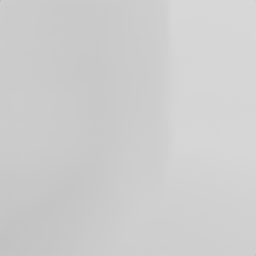

In [111]:
TF.to_pil_image(pred[0] / 2.0 + 0.5)

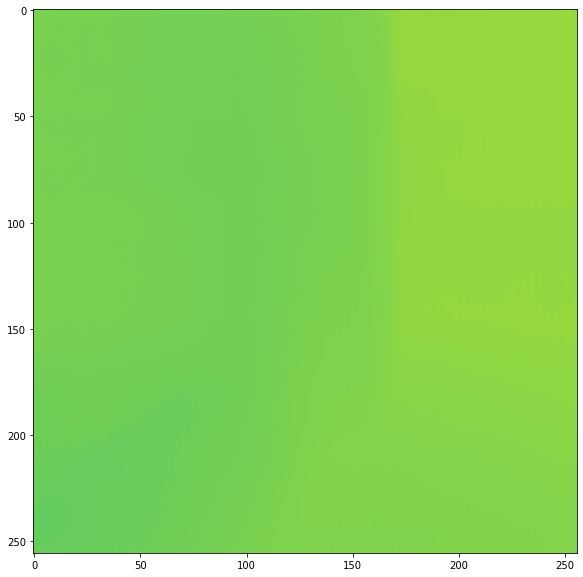

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(pred[0][0] / 2.0 + 0.5, vmin=0, vmax=1)

In [119]:
(pred[0][0] / 2.0 + 0.5).min()

tensor(0.7290)

In [120]:
resize_and_rescale_image_log(np.array(img), None, 1, np.log(2.0 ** 16.0)).min()

0.5598188775976429